Computer's turn
...

Computer placed a Qubit
...

Your turn

Current board:



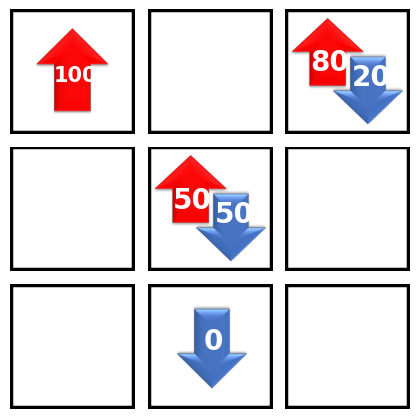


Choose Move:
Enter 0 to place Qubit
Enter 1 to Measure


 1



Choose Measure row (0-2), column(3-5), diagonal(6-7) or Super Measurement(8):


 0


Choose occupied cells, please try again?

Choose Move:
Enter 0 to place Qubit
Enter 1 to Measure


In [ ]:
main()

In [ ]:
!pip install opencv-python-headless


**Basic Prepartion**

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator
import math
import numpy as np
from copy import deepcopy
from IPython.display import clear_output
import sys
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [15]:
measurables = [[0,1,2],[3,4,5],[6,7,8],[0,3,6],[1,4,7],[2,5,8],[0,4,8],[2,4,6]]
probArray = [100, 75, 50, 25, 0]

m = [
    [[100, 100, 0],[100, 100, 0],[0, 0, -1]],
    [[0,0,0],[0,0,0],[0,0,0]],
    [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
]

A = np.array([
    [[70, 67,77],[66,78, 6],[6,67, 11]],
    [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
    [[-1,70,71],[-1,80,82],[84,76,-1]]
])  

NeighborsOfEachPos = {
    0: [1,2,3,6,4,8],
    1: [0,2,4,7],
    2: [0,1,5,8,4,6],
    3: [0,6,4,5],
    4: [3,5,1,7,0,8,2,6],
    5: [3,4,2,8],
    6: [0,3,7,8,4,2],
    7: [1,4,6,8],
    8: [0,4,6,7,2,5],
}

**Quantum Module for simulation**

In [23]:
SuperMeasureIndexes = []
SuperMeasureValue = 0

def makeQuantumCircuit(m, Indexes, superMeasure):
    qc = QuantumCircuit(9,9)
    placeQubits(m, qc)
    EntangleQubits(m, qc)
    measureAll = [0,1,2,3,4,5,6,7,8]
    qc.measure(measureAll, measureAll)
    o = simulate(qc)
    o = o[::-1]
    if superMeasure:
        return checkAllMeasures(o, Indexes)
    else:
        return (o[Indexes[0]] == o[Indexes[1]]) and (o[Indexes[1]] == o[Indexes[2]])
       
    
def placeQubits(m, qc):
    for i in range(0,3):
        for j in range(0,3):
            if m[2][i][j] == -1 and  m[0][i][j] != -1:
                 qc.unitary(makeOperator(m[0][i][j]), [3*i + j], label = str(m[0][i][j])) 
                  
            
def EntangleQubits(m, qc):  
    for i in range(0,3):
        for j in range(0,3):
            if m[2][i][j] >= 70 and m[2][i][j] < 80:
                qc.barrier()
                qc.cx(m[2][i][j] - 70, 3*i + j)
            if m[2][i][j] >= 80 and m[2][i][j] < 90:
                qc.barrier()
                qc.x(3*i + j)
                qc.cx(m[2][i][j] - 80, 3*i + j)
            
            
def makeOperator(probability):
    angle = math.acos(np.sqrt(probability/100))
    return Operator([
    [math.cos(angle),  math.sin(angle)],
    [-math.sin(angle), math.cos(angle)]
    ])

def checkAllMeasures(o, index):
    for m in measurables:
        if((o[m[0]] == o[m[1]]) and (o[m[1]] == o[m[2]])):
            if m[0] in index and m[1] in index and m[2] in index:
                SuperMeasureIndexes = m
                SuperMeasureValue = o[m[0]]
                return True
    return False

def simulate(qc):
    sim = Aer.get_backend('aer_simulator')
    transpiled = transpile(qc, sim)
    result = sim.run(transpiled, shots=1, memory = True).result()
    o = result.get_memory()[0]
    return o


**User Move**

In [25]:
def userMove(Q):
    print("\nCurrent board:\n")
    #display(Q)
    display2(Q)
    Repeat = True
    while Repeat == True:
        print("\nChoose Move:\nEnter 0 to place Qubit\nEnter 1 to Measure")
        move = int(input())
        if move == 0:
            print("\nWhere do you want to place a Qubit? Choose from 0-8:")
            cell = int(input())
            if cell > 8 or cell < 0:
                print("Choice out of bounds, Please choose a vlaue between 0-8")
            elif Q[0][cell//3][cell%3] == -1:
                return provideQubitChoices(Q, cell)
                Repeat = False
            else:
                print("\nYou chose a Non-Empty Cell, Please try again:")
        elif move == 1:
            print("\nChoose Measure row (0-2), column(3-5), diagonal(6-7) or Super Measurement(8):")
            index = int(input())
            if index == 8:
                return Q, FindAllOccupiedIndices(Q[0][:][:])
            else:
                x = measurables[index]
                if Q[0][x[0]//3][x[0]%3] != -1 and Q[0][x[1]//3][x[1]%3] != -1 and Q[0][x[2]//3][x[2]%3] != -1:
                    Repeat = False
                    return Q, measurables[index]
                else:
                    print("Choose occupied cells, please try again?")
        else:
            print("Wrong choice: re-enter")
            Repeat = True

def FindAllOccupiedIndices(A):
    m = []
    for i in range(0,3):
        for j in range(0,3):
            if(A[i][j] != -1):
                m.append(A[i][j])
    return m

            
def provideQubitChoices(Q, cell):
    print("\nQubit Choices:\n0. 100/0\n1. 75/25\n2. 50/50\n3. 25/75\n4. 0/100\n5. Entangle positive\n6. Entangle negative")
    choice = int(input())
    if choice <= 4:
        Q[0][cell//3][cell%3] = probArray[choice]
        return Q, 0
    elif choice <= 6:
        while True:
            print("\nEnter position of control Qubit (0-8)")
            pos = int(input())
            if Q[0][pos//3][pos%3] == -1:
                print("\nPlease choose an occupied block?")
            else:
                Q[2][cell//3][cell%3] = (choice + 2)*10 + pos
                if choice == 5: 
                    Q[0][cell//3][cell%3] = Q[0][pos//3][pos%3]
                else:
                    Q[0][cell//3][cell%3] = 100 - Q[0][pos//3][pos%3]
                break
        return Q, 0
    else:
        print("Invalid Choice, Please try again with a value between 0 and 6")
        return provideQubitChoices(Q, cell)


**Display Board**

In [6]:
def display2(Ar):
    fig = plt.figure(figsize=(5, 5))
    rows = 3
    columns = 3    
    
    for imageNo in range (0,9):

        if (Ar[0][imageNo//3][imageNo%3] != -1 and Ar[2][imageNo//3][imageNo%3]==-1):
            #print("qubit cell")
            if(Ar[0][imageNo//3][imageNo%3] == 100):
                img = Image.open("DisplayPresets/Up.png")
                plt.subplot(3,3,imageNo+1)
                plt.imshow(img)
                plt.axis('off')
                plt.text(120,200, str(Ar[0][imageNo//3][imageNo%3]), color="white", fontdict={"fontsize":15, "fontweight":'bold', "ha":"left", "va":"baseline"})
            elif(Ar[0][imageNo//3][imageNo%3] == 0):
                img = Image.open("DisplayPresets/Down.png")
                plt.subplot(3,3,imageNo+1)
                plt.imshow(img)
                plt.axis('off')
                plt.text(155,180, str(Ar[0][imageNo//3][imageNo%3]), color="white", fontdict={"fontsize":20, "fontweight":'bold', "ha":"left", "va":"baseline"})
            else:
                img = Image.open("DisplayPresets/Plain.png")
                plt.subplot(3,3,imageNo+1)
                plt.imshow(img)
                plt.axis('off')
                plt.text(70,170, str(Ar[0][imageNo//3][imageNo%3]), color="white", fontdict={"fontsize":20, "fontweight":'bold', "ha":"left", "va":"baseline"})
                plt.text(185,210, str(100-Ar[0][imageNo//3][imageNo%3]), color="white", fontdict={"fontsize":20, "fontweight":'bold', "ha":"left", "va":"baseline"})
        elif (Ar[0][imageNo//3][imageNo%3] != -1 and Ar[2][imageNo//3][imageNo%3] != -1): 
            #print("entangled cell")
            img = Image.open("DisplayPresets/Plain2.png")
            plt.subplot(3,3,imageNo+1)
            plt.imshow(img)
            plt.axis('off')
            if(Ar[2][imageNo//3][imageNo%3] < 79):
                #print("E+",Ar[2][i][j] - 70, end = "\t| ")
                plt.text(95,185, "E+" + str(Ar[2][imageNo//3][imageNo%3] - 70), color="white", fontdict={"fontsize":20, "fontweight":'bold', "ha":"left", "va":"baseline"}) 
            else:
                plt.text(95,185, "E-" + str(Ar[2][imageNo//3][imageNo%3] - 80), color="white", fontdict={"fontsize":20, "fontweight":'bold', "ha":"left", "va":"baseline"}) 
         
        else:
            #print("empty cell")
            img = Image.open("DisplayPresets/Empty.png")
            plt.subplot(3,3,imageNo+1)
            plt.imshow(img)
            plt.axis('off')

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    plt.show()
    #print(Ar)


**Computer Choice and Placement**

In [7]:
def DecideMoveOrMeasure(Q):
    prod0 = []
    prod1 = []
    x = 0
    for m in measurables:
        p0 = 1
        p1 = 1
        for index in m:
            if(Q[0][index//3][index%3] == -1):
                p0 = p0*0
                p1 = p1*0
            else:
                if(Q[2][index//3][index%3] >= 80):
                    pos = Q[2][index//3][index%3] - 80
                    if(PositionIsInM(pos, m)):
                        p0 = 0
                        p1 = 0
                    else:
                        p0 = p0*(1-Q[0][pos//3][pos%3]/100)
                        p1 = p1*(Q[0][pos//3][pos%3]/100)
                elif(Q[2][index//3][index%3] >= 70):
                    pos = Q[2][index//3][index%3] - 70
                    if(not PositionIsInM(pos, m)):
                        p0 = p0*Q[0][pos//3][pos%3]/100
                        p1 = p1*(1 - Q[0][pos//3][pos%3]/100)
                else:
                    p0 = p0*Q[0][index//3][index%3]/100
                    p1 = p1*(1-Q[0][index//3][index%3]/100)
        prod0.append(p0)
        prod1.append(p1)
        x = x+1
    max0 = max(prod0)
    max1 = max(prod1)
    if not checkEmptySpace(Q):
        if max0 > max1:
            return Q, measurables[prod0.index(max0)]
        else:
            return Q, measurables[prod1.index(max1)]
    if(max0 > 0.5 or max1 > 0.5):
        if(max0 > max1):
            index = prod0.index(max0)
            return Q, measurables[index]
        else:
            index = prod1.index(max1)
            return Q, measurables[index]
    else:
        return (DecideMoveSquare(Q))
                
def DecideMoveSquare(Q):
    N = deepcopy(Q)
    pos = []
    zeroRatio = []
    score = []
    for p in range(0,9):
        if N[0][p//3][p%3] == -1:
            pos.append(p)
            z = math.floor(computerMove(Q, p)*100)
            zeroRatio.append(z)
            N[0][p//3][p%3] = z
            score.append(FindScore(N))
            N[0][p//3][p%3] = Q[0][p//3][p%3]
    maximum = max(score)    
    index = score.index(maximum)
    p = pos[index]
    Q[0][p//3][p%3] = 10*round(zeroRatio[index]/10)
    return Q, 0
    
def FindScore(Q):
    score = 0
    for m in measurables:
        i, j, k = m[0], m[1], m[2]
        a, b, c = Q[0][i//3][i%3]/100, Q[0][j//3][j%3]/100, Q[0][k//3][k%3]/100
        if(not(a < 0 or b < 0 or c < 0)):
            score = score + a*b*c + (1-a)*(1-b)*(1-c)
    return 8 - score   
    
def PositionIsInM(pos, M):
    for m in M:
        if(pos == m): 
            return True
    return False

def checkEmptySpace(Q):
    for i in range(0,9):
        if Q[0][i//3][i%3] == -1:
            return True
    return False

**Computer Evaluation Hueristics**

In [8]:
def computerMove(Q, pos):
    neighbours = NeighborsOfEachPos[pos]
    zeroes = 0
    ones = 0
    for i in range(0, len(neighbours), 2):
        c0, c1 = QMoveMaker(Q, neighbours[i], neighbours[i+1])
        zeroes = zeroes + c0
        ones = ones + c1
    return zeroes/(zeroes + ones)
        
def QMoveMaker(Q, p1, p2):
    qc = QuantumCircuit(3,1)
    #print("Inside QMoveMaker",Q)
    if(Q[0][p1//3][p1%3] != -1 and Q[0][p2//3][p2%3] != -1):
        #print("making operators using:",Q[0][p1//3][p1%3],Q[0][p1//3][p1%3])
        qc.unitary(makeOperator(Q[0][p1//3][p1%3]), 0, label = str(Q[0][p1//3][p1%3]))
        qc.unitary(makeOperator(Q[0][p2//3][p2%3]), 1, label = str(Q[0][p2//3][p2%3]))
        qc.x(2)
        qc.cx(0,2)
        qc.cx(1,2)
    elif Q[0][p1//3][p1%3] != -1:
        qc.unitary(makeOperator(Q[0][p1//3][p1%3]), 0, label = str(Q[0][p1//3][p1%3]))
        qc.cx(0,2)
    elif Q[0][p2//3][p2%3] != -1:
        qc.unitary(makeOperator(Q[0][p2//3][p2%3]), 1, label = str(Q[0][p2//3][p2%3]))
        qc.cx(1,2)
    qc.measure([2],[0])
    #print("Inside QMove:", qc)
    #print("Using positions", p1, p2)
    sim = Aer.get_backend('aer_simulator')
    transpiled = transpile(qc, sim)
    result = sim.run(transpiled, shots=100, memory = True).result()
    c = result.get_counts()
    if '0' in c.keys():
        zero = c['0']
    else:
        zero = 0
    if '1' in c.keys():
        one = c['1']
    else:
        one = 0
    return zero, one

**Removing Entanglements**

In [9]:
def removeEntangles(A, MeasureAlong):
    for m in MeasureAlong:
        for i in range(0,3):
            for j in range(0,3):
                if(A[2][i][j] == (70 + m) or A[2][i][j] == (80 + m)):
                    A[0][i][j] = -1
                    A[2][i][j] = -1
            

**Main Function**

In [10]:
def main():
    A = np.array([
        [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
        [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
        [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]]
    ])
    NumMeasurePlayer = 0
    NumMeasureComputer = 0
    GameOver = False
    
    try:
        while not GameOver:
            print("Your turn")
            A, MeasureAlong = userMove(A)
            if MeasureAlong != 0:
                NumMeasurePlayer = NumMeasurePlayer + 1
                Super = len(MeasureAlong) > 3
                #print("MeasureAlong for user is: ", MeasureAlong)
                #print("A for user is:",A)
                GameOver = makeQuantumCircuit(A, MeasureAlong, Super)
                if Super:
                    if GameOver:
                        print("\nSuper Measure successful. You measured: ",SuperMeasureValue, "at indices: ",SuperMeasureIndexes)
                    else:
                        print("\nSuper measured failed. You Lose!")
                    sys.exit(0)
                else:
                    if GameOver:
                        print("\nYou measured correctly! You win!")
                        sys.exit(0)
                    elif NumMeasurePlayer >= 5:
                        print("\nYou have exhausted all your measurement moves! You lose!")
                        sys.exit(0)
                    else:
                        print("\nOops. Measurement failed. No worries, keep playing. You have ",(5 - NumMeasurePlayer), " Measurement moves left!")
                        A[0][MeasureAlong[0]//3][MeasureAlong[0]%3] = -1
                        A[0][MeasureAlong[1]//3][MeasureAlong[1]%3] = -1
                        A[0][MeasureAlong[2]//3][MeasureAlong[2]%3] = -1
                        A[2][MeasureAlong[0]//3][MeasureAlong[0]%3] = -1
                        A[2][MeasureAlong[1]//3][MeasureAlong[1]%3] = -1
                        A[2][MeasureAlong[2]//3][MeasureAlong[2]%3] = -1
                        removeEntangles(A, MeasureAlong)
            clear_output(wait = True)
            print("Computer's turn\n...\n")
            A, MeasureAlong = DecideMoveOrMeasure(A)
            if MeasureAlong != 0:
                NumMeasureComputer = NumMeasureComputer + 1
                GameOver = makeQuantumCircuit(A, MeasureAlong, False)
                if GameOver:
                    print("\nThe Computer choose to measure along", MeasureAlong, " and won. You lose!")
                    sys.exit(0)
                elif NumMeasureComputer >= 5:
                    print("The Computer exhuasted all its Measurement moves. You Win!")
                    sys.exit(0)
                else:
                    print("\nThe Computer choose to measure along", MeasureAlong, " but failed! You're lucky")
                    A[0][MeasureAlong[0]//3][MeasureAlong[0]%3] = -1
                    A[0][MeasureAlong[1]//3][MeasureAlong[1]%3] = -1
                    A[0][MeasureAlong[2]//3][MeasureAlong[2]%3] = -1
                    A[2][MeasureAlong[0]//3][MeasureAlong[0]%3] = -1
                    A[2][MeasureAlong[1]//3][MeasureAlong[1]%3] = -1
                    A[2][MeasureAlong[2]//3][MeasureAlong[2]%3] = -1
                    removeEntangles(A, MeasureAlong)
            else:
                print("Computer placed a Qubit\n...\n")
    
    except SystemExit:
        print("\n...\n\nGAME OVER\n\n...\n\nRerun the main code cell to play again!")
